<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each_Fullset_Fullpoints_Round2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


In [ ]:
!nvidia-smi

Wed Jul  7 08:57:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

# 1. Initialize

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'trained_models',
 'DataPreprocessing.ipynb',
 'checkpoints',
 'Heatmap_each.ipynb',
 'Update_leaf.ipynb',
 'Solve_RF_increase.ipynb',
 'Untitled0.ipynb',
 'Heatmap_each_Fullset_Fullpoints.ipynb']

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from utils.hourglass import *
from utils.dataloader import *

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim_tree = 5 # how deep the regression tree is 
num_tree = 3 # number of regression trees
variance_gaussian = 3

num_fc = int(num_tree*(2**(dim_tree-1)-1))
num_leaf_nodes = int(num_tree*2**(dim_tree-1))

# 2. Data Loader

In [ ]:
helen_trainset = Helen_set(dataset_type="train",var=variance_gaussian)
train_dataloder = DataLoader(helen_trainset, batch_size=20)

Loading [1/2000] pictures......
Loading [400/2000] pictures......
Loading [800/2000] pictures......
Loading [1200/2000] pictures......
Loading [1600/2000] pictures......
Loading [2000/2000] pictures......


In [ ]:
# helen_testset = Helen_set(dataset_type="test",var=variance_gaussian)
# test_dataloder = DataLoader(helen_testset, batch_size=10)

Loading [1/330] pictures......
Loading [200/330] pictures......


# 3. Pre Train

In [ ]:
# helen_sampleset = Helen_set(dataset_type="sample")
# sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

In [ ]:
# critical = torch.nn.MSELoss()

# nIters = 200
# HGNet = HGNet().to(device)
# optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
# loss_hist = torch.zeros(nIters)
# loss_epoch = torch.zeros(10)

# for iter in range(nIters):
#   for i, (x,_,y) in enumerate(sample_dataloder):
#     x = Variable(x,requires_grad=True).float().to(device)
#     y = Variable(y).float().to(device)
#     y_pred = HGNet.forward(x)
#     loss = critical(y_pred, y)
#     loss_epoch[i] = loss.item()

#     if i == 9:
#       loss_avg = torch.sum(loss_epoch)/10
#       loss_hist[iter] = loss_avg
#       if (iter+1)%10 == 0 or iter == 0:
#         print('Iter [%d/%d] loss %.4f' %(iter+1, nIters, loss_avg))
        
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
# plt.title("Training Loss")

In [ ]:
# torch.save(HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt")

# 4. Tune Training

## 4.1 Functions

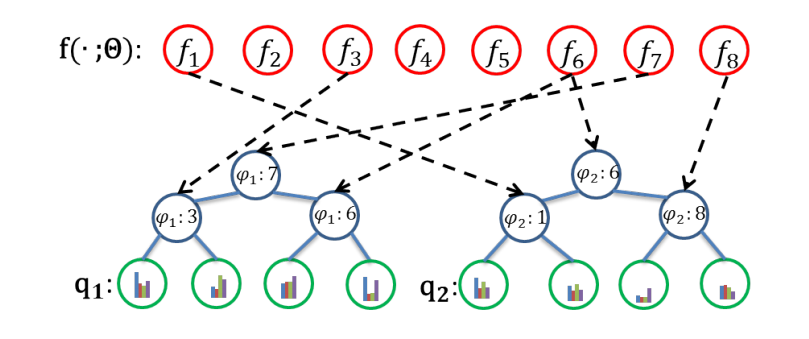

In [ ]:
def leaf_direction(N):
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point.int()

In [ ]:
def split_tree(up,here,which=0,mode='Second'):
  if mode=='initial':
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [ ]:
def split_base(N):
  # returns index that split based on which cnn_fc col
  res = torch.zeros(2**N*N).to(device)
  lenth = 2**(N-1)
  num = 1
  left = 0
  repeat = 1
  max_repeat = 1
  while lenth>0 and repeat<2**N:
    res[left:left+lenth*2] = num
    left += lenth*2
    num += 1
    repeat -= 1
    if repeat == 0:
      lenth = int(lenth/2)
      repeat = max_repeat*2
      max_repeat = repeat
  return ((res.reshape(N,2**N)-1).T).int()

In [ ]:
def phi(cnn_fc,mode='train'):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,num_leaf_nodes).to(device)
  sigm = torch.zeros(cnn_fc.shape).to(device)

  if mode == 'test':
    sigm[cnn_fc>0] = 1
  else:
    sigm = torch.sigmoid(cnn_fc)

  direction = leaf_direction(dim_tree-1)
  tree_ind = split_base(dim_tree-1)
  X, Y = tree_ind.shape

  for ind_tree in range(num_tree):
    for x in range(X):
      for y in range(Y):
        here = sigm[:,ind_tree*(X-1)+tree_ind[x,y]]
        if y == 0:
          up = split_tree(torch.rand(3).to(device),here,which=direction[x,y],mode='initial')
        else:
          up = split_tree(up,here,which=direction[x,y])
        #print('y',y,'up',up)

      out[:,ind_tree*X+x] = up
    
  return out

In [ ]:
def find_coord(prob_map):
  # prob_map(200,68*256*256)

  N = prob_map.shape[0]
  P = 68
  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [ ]:
def get_mask(cnn_heatmaps,threshold=0.3):
  mask = torch.zeros(cnn_heatmaps.shape).to(device)
  B, P = cnn_heatmaps.shape[0:2]
  for b in range(B):
    for p in range(P):
      hm = cnn_heatmaps[b,p,:,:]
      mask[b,p,:,:][hm>torch.max(hm)*threshold]=1
  return mask

In [ ]:
def update_iter(q, p, l):
  # q: leaf node
  # p: cnn probability
  # l: label

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (Ntrain,Nleaf,Nlabel)
  gamma = gamma/(torch.sum(gamma,axis=1,keepdims=True)+1e-8)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0)+1e-8 # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [ ]:
def loss_ce(B, q, p, l):
  pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*68,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*68,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -criterion_KL(l,pred)

def loss_l1(q, p, l):
  return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

def loss_alogb(B, q, p, l):
  pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*68,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*68,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -torch.sum(l*torch.log(pred))/B

In [ ]:
# def mask_and_norm(target, mask):
#   # target (B,12,256,256)
#   # mask (B,12,256,256)
#   B,P = target.shape[0:2]

#   res = (target*mask).reshape(B,P,-1)
#   res = res/torch.sum(res,axis=2,keepdims=True)
#   return res.reshape(B,-1)

## 4.2 Sample Set

In [ ]:
# helen_sampleset = Helen_set(dataset_type="sample",var=variance_gaussian)
# sample_dataloder = DataLoader(helen_sampleset, batch_size=20) 
# helen_sampletest = Helen_set(dataset_type="sample_test",var=variance_gaussian)
# sample_test_dataloder = DataLoader(helen_sampletest, batch_size=10)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......
Loading [1/30] pictures......


## 4.3 Network

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
# Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

In [ ]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/Anneal_Fullset_Fullpoints/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round1.pt")))
leaf_q = torch.load(os.path.join("checkpoints/Anneal_Fullset_Fullpoints/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round1.pt"))

## 4.4 Training

In [ ]:
#######################
# Initialization
Total_train = 3

# CNN initilization
nIters = 200
learning_rate = 0.01

criterion_MSE = torch.nn.MSELoss()
criterion_KL = torch.nn.KLDivLoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 60

### Training using L2 Loss

In [ ]:
# Using L2 Loss

for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  
  #####################################
  ### Train Hourglass
  ### eyes: [36:48]
  #####################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12*256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)
      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q).reshape(B,12,256,256)
      # get mask for computing cnn loss
      cnn_mask = get_mask(cnn_heatmaps,threshold=0.5)
      loss = criterion_MSE(cnn_heatmaps*cnn_mask, y[:,36:48,:,:]*cnn_mask)

      loss_epoch += loss.item()
      if (iter+1)%20 == 0 or iter == 0:
        if i == 9:
          print('     CNN training, Iter [%d/%d], loss_L2: %.8f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


  #####################################
  ### Train Regression Trees using pinv
  #####################################
  with torch.no_grad():
    leaf_q_new = torch.zeros(num_leaf_nodes,12*256*256).to(device)
    loss0 = 0

    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

      leaf_q_new += torch.matmul(torch.linalg.pinv(cnn_prob), y_expand) #(8,12*256*256)

    leaf_q = leaf_q_new/10  # average among each bach
    leaf_q = torch.abs(leaf_q.reshape(num_leaf_nodes,12,-1)) #(B,12,256*256)
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    for nleaf in range(num_leaf_nodes):
      for npoints in range(12):
        leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    leaf_q = leaf_q.reshape(num_leaf_nodes,-1)

    print("     RF training, coordinate loss: %.4f" %(loss0/10))





###########################################################
Round 1, Using GPU


NameError: ignored

### Training using Log likelihood

############################################################################
Round [2/3], Using GPU
     CNN training, Iter [1/200], loss_CE: 566.9482
     CNN training, Iter [5/200], loss_CE: 566.5949
     CNN training, Iter [10/200], loss_CE: 566.5931
     CNN training, Iter [15/200], loss_CE: 566.5929
     CNN training, Iter [20/200], loss_CE: 566.5929
     CNN training, Iter [25/200], loss_CE: 566.5929
     CNN training, Iter [30/200], loss_CE: 566.5929
     CNN training, Iter [35/200], loss_CE: 566.5929
     CNN training, Iter [40/200], loss_CE: 566.5929
     CNN training, Iter [45/200], loss_CE: 566.5929
     CNN training, Iter [50/200], loss_CE: 566.5929
     CNN training, Iter [55/200], loss_CE: 566.5929
     CNN training, Iter [60/200], loss_CE: 566.5929
     CNN training, Iter [65/200], loss_CE: 566.5929
     CNN training, Iter [70/200], loss_CE: 566.5929
     CNN training, Iter [75/200], loss_CE: 566.5929
     CNN training, Iter [80/200], loss_CE: 566.5929
     CNN training,

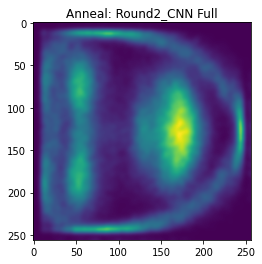

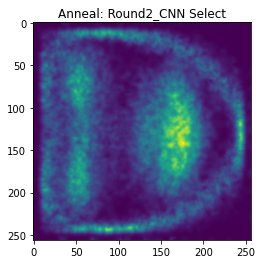

     RF training, Batch 1, rf_iter [1/60], loss_CE: 507.6248
     RF training, Batch 1, rf_iter [10/60], loss_CE: 507.5012
     RF training, Batch 1, rf_iter [20/60], loss_CE: 507.5012
     RF training, Batch 1, rf_iter [30/60], loss_CE: 507.5012
     RF training, Batch 1, rf_iter [40/60], loss_CE: 507.5012
     RF training, Batch 1, rf_iter [50/60], loss_CE: 507.5012
     RF training, Batch 1, rf_iter [60/60], loss_CE: 507.5012
     RF training, Batch 5, rf_iter [1/60], loss_CE: 514.6640
     RF training, Batch 5, rf_iter [10/60], loss_CE: 514.4933
     RF training, Batch 5, rf_iter [20/60], loss_CE: 514.4933
     RF training, Batch 5, rf_iter [30/60], loss_CE: 514.4933
     RF training, Batch 5, rf_iter [40/60], loss_CE: 514.4933
     RF training, Batch 5, rf_iter [50/60], loss_CE: 514.4933
     RF training, Batch 5, rf_iter [60/60], loss_CE: 514.4933
     RF training, Batch 10, rf_iter [1/60], loss_CE: 512.1853
     RF training, Batch 10, rf_iter [1/60], loss_CE: 512.1853
     RF tr

In [ ]:
# update using log likelihood

time_initial = time.time()
for round in range(1,3):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))

  
  ######################################################
  ### Train Hourglass using gradient decent
  ### eyes: [36:48]
  ######################################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,68,256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(train_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)

      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*68,-1)
      cnn_heatmaps = cnn_heatmaps/torch.sum(cnn_heatmaps,axis=1,keepdims=True)
      label_heatmaps = y.reshape(B*68,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)
      #loss = -criterion_KL(cnn_heatmaps,label_heatmaps)
      loss = -torch.sum(label_heatmaps*torch.log(cnn_heatmaps+1e-8))/B

      loss_epoch += loss.item()
      if (iter+1)%5 == 0 or iter == 0:
        if i == 99:
          loss_epoch = loss_epoch/100
          print('     CNN training, Iter [%d/%d], loss_CE: %.4f' %(iter+1, cnn_Iters, loss_epoch))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # calculate time for CNN training
  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))

  # plot the face after CNN training
  # Does not select
  cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,68,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Full")
  plt.savefig(os.path.join("checkpoints/Anneal_Fullset_Fullpoints/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN_Full.png"))
  plt.show()

  # Selcet
  cnn_prob_test = phi(outputs, mode='test')
  cnn_heatmaps = torch.matmul(cnn_prob_test,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,68,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Select")
  plt.savefig(os.path.join("checkpoints/Anneal_Fullset_Fullpoints/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN_Select.png"))
  plt.show()

  ######################################################
  ### Train Regression Trees using variational bounding
  ######################################################
  with torch.no_grad():
    loss0,loss_select = 0,0
    leaf_q = leaf_q.reshape(num_leaf_nodes,68,256*256)
    new_leaf_q = torch.zeros(leaf_q.shape).to(device)

    for i, (x,coord,y) in enumerate(train_dataloder):
      next_leaf_q = leaf_q.clone()
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y.reshape(B,68,-1) #(200,68*256*256)

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)
      cnn_prob_select = phi(outputs, mode='test')
  
      for rf_iter in range(rf_Iters):
        for points_id in range(68):
          next_leaf_q[:,points_id,:] = update_iter(next_leaf_q[:,points_id,:], cnn_prob, y_expand[:,points_id,:])
        if ((i+1)%5 == 0 or i == 0) and ((rf_iter+1)%10 == 0 or rf_iter == 0):
          rf_loss_CE = loss_alogb(B, next_leaf_q, cnn_prob, y_expand)
          print("     RF training, Batch %d, rf_iter [%d/%d], loss_CE: %.4f" %(i+1, rf_iter+1, rf_Iters, rf_loss_CE))

      # Calculate loss
      pred_coord0 = find_coord(torch.matmul(cnn_prob,next_leaf_q.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord.reshape(B,-1)))/B
      pred_coord_select = find_coord(torch.matmul(cnn_prob_select,next_leaf_q.reshape(num_leaf_nodes,-1)))
      loss_select += torch.sum(torch.abs(pred_coord_select-coord.reshape(B,-1)))/B

      # update leaf node
      new_leaf_q += next_leaf_q
    leaf_q = new_leaf_q/torch.sum(new_leaf_q, axis=2, keepdims=True)
    


  # plot the face after rf training
  # Does not select
  rf_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,68,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Full")
  plt.savefig(os.path.join("checkpoints/Anneal_Fullset_Fullpoints/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF_Full.png"))
  plt.show()

  # Select
  cnn_prob_test = phi(outputs, mode='test')
  rf_heatmaps = torch.matmul(cnn_prob_test,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,68,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Select")
  plt.savefig(os.path.join("checkpoints/Anneal_Fullset_Fullpoints/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF_Select.png"))
  plt.show()

  print("     RF training, coordinate loss: %.2f, after selcetion: %.2f" %(loss0/100, loss_select/100))

  # save parameters for this round
  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Anneal_Fullset_Fullpoints/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))
  torch.save(leaf_q, os.path.join("checkpoints/Anneal_Fullset_Fullpoints/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))

  # calculate time for rf training
  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Anneal_Fullset_Fullpoints/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/Anneal_Fullset_Fullpoints/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

# calculate total training time
time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

In [ ]:
for ith in range(20):
  px = pred_coord0[ith,::2].detach().cpu()
  py = pred_coord0[ith,1::2].detach().cpu()

  lx = coord[ith,:,0].detach().cpu()
  ly = coord[ith,:,1].detach().cpu()

  plt.scatter(lx,256-ly,label='Label')
  plt.scatter(px,256-py,label='Prediction')

  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th Train Sample - Full")
  plt.legend(loc='lower left')
  plt.show()

In [ ]:
for ith in range(20):
  px = pred_coord_select[ith,::2].detach().cpu()
  py = pred_coord-select[ith,1::2].detach().cpu()

  lx = coord[ith,:,0].detach().cpu()
  ly = coord[ith,:8,1].detach().cpu()

  plt.scatter(lx,256-ly,label='Label')
  plt.scatter(px,256-py,label='Prediction')

  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th Train Sample - Select")
  plt.legend(loc='lower left')
  plt.show()

## 4.5 Test

### Restore from saved weights

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/Anneal_Full_Train_V100/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round6.pt")))
leaf_q = torch.load(os.path.join("checkpoints/Anneal_Full_Train_V100/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round6.pt"))

In [ ]:
import torchsummary
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
torchsummary.summary(Tune_HGNet, (3,256,256))
print('parameters_count:',count_parameters(Tune_HGNet))

### Test

In [ ]:
def NME_eye(pred_coord, label_coord):
  # pred_coord(B,12*2)
  x = pred_coord[:,::2]
  y = pred_coord[:,1::2]
  x_label = label_coord[:,::2]
  y_label = label_coord[:,1::2]

  x_center_left = torch.sum(x[:,0:6],axis=1,keepdims=True)/6
  x_center_right = torch.sum(x[:,6:12],axis=1,keepdims=True)/6
  y_center_left = torch.sum(y[:,0:6],axis=1,keepdims=True)/6
  y_center_right = torch.sum(y[:,6:12],axis=1,keepdims=True)/6
  dist = torch.sqrt((x_center_left-x_center_right)**2 + (y_center_left-y_center_right)**2)

  Err = torch.sqrt((x-x_label)**2 + (y-y_label)**2)/dist
  return torch.sum(Err)/x.shape[0]/12

def NME_full(pred_coord, label_coord):
  # pred_coord(B,68*2)
  x = pred_coord[:,::2]
  y = pred_coord[:,1::2]
  x_label = label_coord[:,::2]
  y_label = label_coord[:,1::2]

  x_center_left = torch.sum(x[:,0:6],axis=1,keepdims=True)/6
  x_center_right = torch.sum(x[:,6:12],axis=1,keepdims=True)/6
  y_center_left = torch.sum(y[:,0:6],axis=1,keepdims=True)/6
  y_center_right = torch.sum(y[:,6:12],axis=1,keepdims=True)/6
  dist = torch.sqrt((x_center_left-x_center_right)**2 + (y_center_left-y_center_right)**2)

  Err = torch.sqrt((x-x_label)**2 + (y-y_label)**2)/dist
  return torch.sum(Err)/x.shape[0]/68

In [ ]:
NME_loss_select = NME_loss = coord_loss = coord_loss_select = 0
Tune_HGNet.eval()

for i, (img,coord,hm) in enumerate(test_dataloder):
  img = img.float().to(device)
  img.requires_grad = True
  coord = coord.float().to(device)
  hm = hm.float().to(device)
  B = img.shape[0]
  
  outputs = Tune_HGNet.forward(img)
  pred_heatmaps = torch.matmul(phi(outputs),leaf_q.reshape(num_leaf_nodes,-1)) #(15,12*256*256)
  pred_heatmaps_select = torch.matmul(phi(outputs,mode='test'),leaf_q.reshape(num_leaf_nodes,-1)) #(15,12*256*256)
  pred_coord0 = find_coord(pred_heatmaps)
  pred_coords = find_coord(pred_heatmaps_select) #(15,12*2)

  # coord_loss += torch.sum(torch.abs(pred_coord0-coord.reshape(B,-1)))/B
  # coord_loss_select += torch.sum(torch.abs(pred_coords-coord.reshape(B,-1)))/B
  # NME_loss += NME_eye(pred_coord0,coord.reshape(B,-1))
  # NME_loss_select += NME_eye(pred_coords,coord.reshape(B,-1))

  coord_loss += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))/B
  coord_loss_select += torch.sum(torch.abs(pred_coords-coord[:,36:48,:].reshape(B,-1)))/B
  NME_loss += NME_eye(pred_coord0,coord[:,36:48,:].reshape(B,-1))
  NME_loss_select += NME_eye(pred_coords,coord[:,36:48,:].reshape(B,-1))

  

print("Coord L1 loss %.4f, after selection: %.4f" %(coord_loss/33, coord_loss_select/33))
print("Coord NME loss %.4f, after selection: %.4f" %(NME_loss/33, NME_loss_select/33))

Coord L1 loss 140.2624, after selection: 142.9632
Coord NME loss 0.0921, after selection: 0.0939


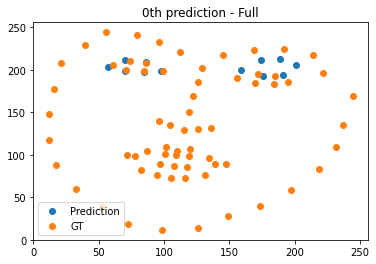

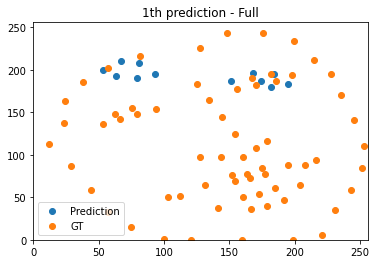

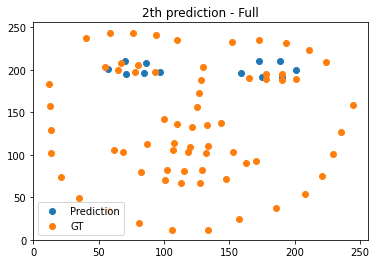

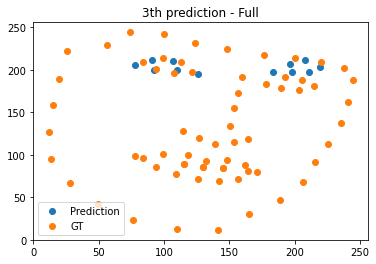

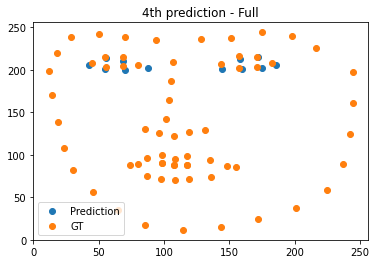

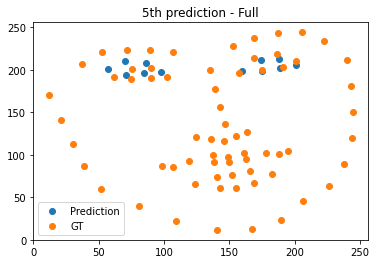

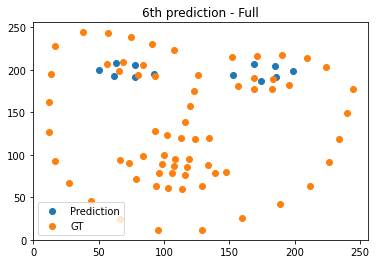

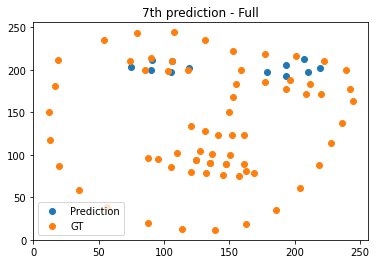

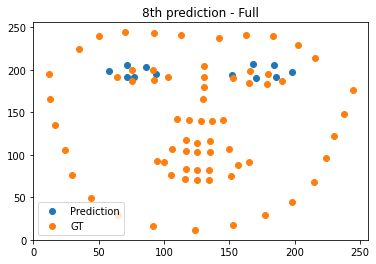

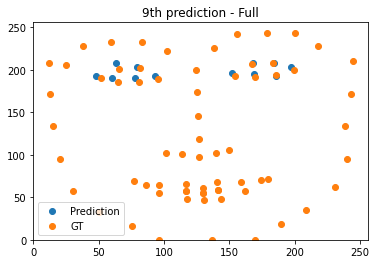

In [ ]:
# Coords

for ith in range(10):
  x = pred_coord0[ith,::2].detach().cpu()
  y = pred_coord0[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction")

  x2 = coord[ith,:,0].detach().cpu()
  y2 = coord[ith,:,1].detach().cpu()
  plt.scatter(x2,256-y2,label="GT")

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th prediction - Full")
  plt.show()

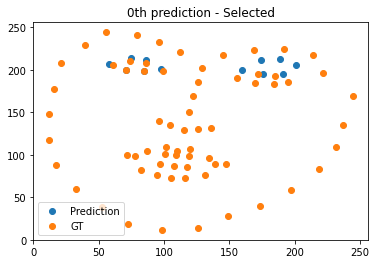

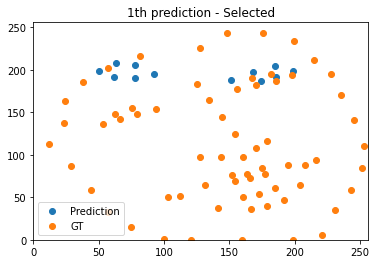

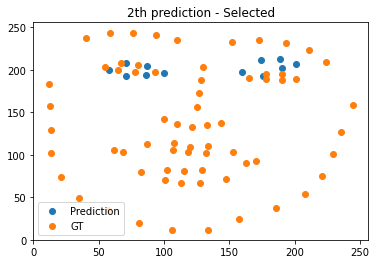

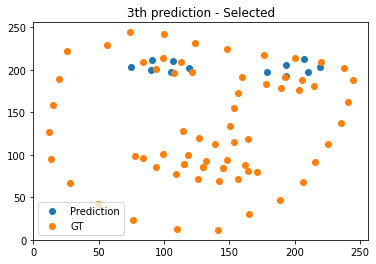

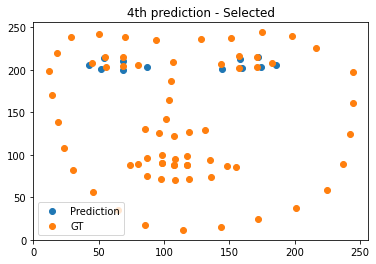

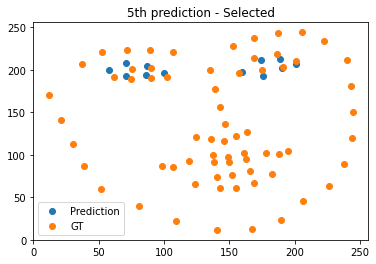

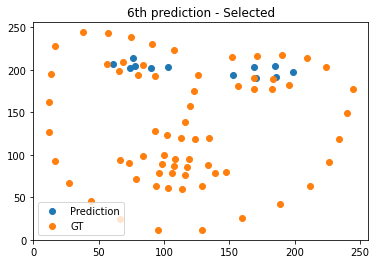

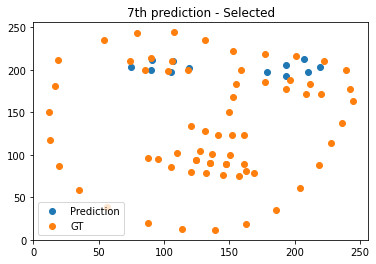

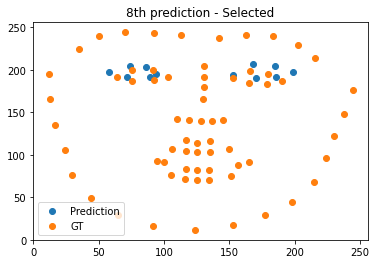

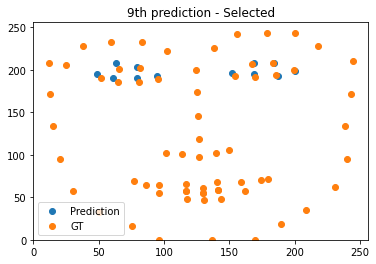

In [ ]:
# Coords

for ith in range(10):
  x = pred_coords[ith,::2].detach().cpu()
  y = pred_coords[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction")

  x2 = coord[ith,:,0].detach().cpu()
  y2 = coord[ith,:,1].detach().cpu()
  plt.scatter(x2,256-y2,label="GT")

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th prediction - Selected")
  plt.show()

In [ ]:
plot_heatmaps = pred_heatmaps.reshape(B,68,256,256).detach().cpu()
plot_heatmaps_all = torch.sum(plot_heatmaps,axis=1)
for ith in range(10):
  plt.imshow(plot_heatmaps_all[ith,:,:])
  plt.title(str(ith)+"th prediction heatmap")
  plt.show()

In [ ]:
for nleaf in range(48):
  plt.imshow(leaf_q.reshape(num_leaf_nodes,68,256,256)[nleaf,0,:,:].detach().cpu())
  plt.title(str(ith)+"th leafnode, first point, first img")
  plt.show()

In [ ]:
image = torch.sum(hm, axis=1).detach().cpu()
plt.imshow(image[ith,:,:])

In [ ]:
plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())